In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pylab as pl
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
#ruta = r"C:\Users\sear2\Music\analisis_frecuencias\Analisis_de_Frecuencias\gastos\datos2014.csv"  # Estupido windows
ruta = "/home/sear/Documentos/repos_git/analisis_frec/Analisis_de_Frecuencias/gastos/gastos_prueba.csv"  # Linux
print(f"\nArchivo: \n {ruta}")


Archivo: 
 /home/sear/Documentos/repos_git/analisis_frec/Analisis_de_Frecuencias/gastos/gastos_prueba.csv


In [4]:
datos = pd.read_csv(ruta, header=None).values  # Se crea un  array
datos.astype(float)
print(type(datos))
len(datos)

<class 'numpy.ndarray'>


42

In [5]:
m = datos.size
rv1 = st.norm
EEstandart = np.full((m, 1), -999, float) # Se crea un vector con m elementos

In [6]:
matriz01 = np.zeros ((m, 6))
matriz02 = np.zeros ((m, 4))
matriz02 [:] = -999
matriz02 [0, 0] = 2
matriz02 [1, 0] = 5
matriz02 [2, 0] = 10
matriz02 [3, 0] = 20
matriz02 [4, 0] = 50
matriz02 [5, 0] = 100
matriz02 [6, 0] = 200
matriz02 [7, 0] = 500
matriz02 [8, 0] = 1000
matriz02 [9, 0] = 2000
matriz02 [10, 0] = 5000
matriz02 [11, 0] = 10000

In [7]:
for i in range (m):
    matriz01 [i, 0] = i + 1             # Se crea la columna para el No de Orden
    matriz01 [i, 1] = datos.max()    # Se crea la columna que contiene los gastos registrados
                                                # ordenado en forma descendente
    j = datos.argmax()               # Returns the indices of the maximum values along
    datos [j, 0] = -1                # an axis

    matriz01 [i, 2] = (m + 1)/matriz01[i,0]     # Se crea la columna con los periodos de retorno
                                                # (Tr) a partir de la columna de los gastos
                                                # registrados ordenados
    matriz01 [i, 3] = 1-(1/matriz01[i, 2])      # Se crea la columna para los valores de F(x)
                                                # a partir de Tr
    matriz01 [i, 4] = -rv1.isf(matriz01[i, 3])  #Se hace el ajuste (z)

In [8]:
EE = 0
mu = 0
sigma = 0
for i in range (m):
    prueba = np.log(matriz01[i, 1])
    mu = mu + prueba
mu = mu/m                                       # Calculo para obtener mu
for i in range (m):
    prueba = (np.log(matriz01[i, 1])-mu)**2
    sigma = sigma + prueba
sigma = np.sqrt(sigma/m)                        # Calculo para obtener sigma


In [9]:
for i in range (m):
    matriz01 [i, 5] = np.exp((matriz01[i, 4] * sigma) + mu)
    prueba = (matriz01 [i, 1] - matriz01 [i, 5]) ** 2  # Error Estandart
    EE = EE + prueba
EE = (EE/(m-2)) ** 0.5                                 # Se estima el Error Estandart para 2 parametros
print ("Error Estandart (Momentos y Máxima verosimilitud), Distribución LogNormal 2 parámetros: ", EE)
EEstandart[0, 0] = EE

Error Estandart (Momentos y Máxima verosimilitud), Distribución LogNormal 2 parámetros:  3.663408102028378


In [10]:
n=12
for j in range (n):
    matriz02 [j, 1] = 1.0 - (1.0/matriz02 [j, 0])            # se crea la columna de F(x)
    matriz02 [j, 2] = -rv1.isf(matriz02[j, 1])               # Se realiza el ajuste (z)
    matriz02 [j, 3] = np.exp((matriz02[j, 2] * sigma) + mu)  # Valores Extrapolados

#********************************************************************************************
# Se crea el DataFrame final
#********************************************************************************************

columnas = ['No Orden', 'Valor Registrado','Tr (Anios)', 'F(x)', 'z', 'Valor Ajustado']
cD = pd.DataFrame(matriz01, columns = columnas)
cD.insert(6, 'Tr', matriz02 [:, 0])
cD.insert(7, 'F(X)', matriz02 [:, 1])
cD.insert(8, 'Z', matriz02 [:, 2])
cD.insert(9, 'Valor Extrapolado', matriz02 [:, 3])
cD.insert(10, 'Error Estandart "Momentos y Máxima verosimilitud"', EEstandart[:, 0])

In [11]:
cD.head()

,No Orden,Valor Registrado,Tr (Anios),F(x),z,Valor Ajustado,Tr,F(X),Z,Valor Extrapolado,"Error Estandart ""Momentos y Máxima verosimilitud"""
0,1.0,80.0,43.000000,0.976744,1.990720,58.969104,2.0,0.50,-0.000000,31.047319,3.663408
1,2.0,52.0,21.500000,0.953488,1.679661,53.344779,5.0,0.80,0.841621,40.720079,-999.000000
2,3.0,51.3,14.333333,0.930233,1.477525,49.980788,10.0,0.90,1.281552,46.922016,-999.000000
3,4.0,51.3,10.750000,0.906977,1.322365,47.543214,20.0,0.95,1.644854,52.749776,-999.000000
4,5.0,49.0,8.600000,0.883721,1.193795,45.613687,50.0,0.98,2.053749,60.179050,-999.000000


In [15]:
cD.to_excel('salidas_notebooks/lognormal_2p_gastos_prueba.xlsx', header=True, sheet_name='gastos_prueba', index=False)

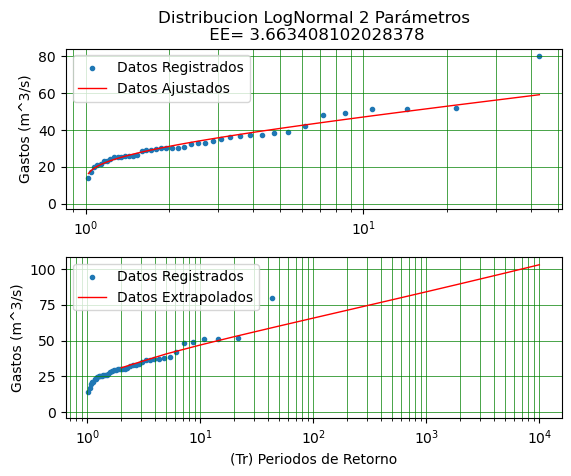

In [13]:
#*********************** * ********************************************************************
# Graficos
#********************************************************************************************

titulo = "Distribucion LogNormal 2 Parámetros\n EE= " + str(EE)
tR = matriz01 [:, 2]
dReg = matriz01 [:, 1]
dAjust = matriz01 [:, 5]
dExtrap = matriz02 [:12, 3]
dTrExtrap = matriz02 [:12, 0]

pl.subplot(2,1,1)
pl.subplots_adjust(hspace=0.3)
pl.scatter(tR, dReg, label='Datos Registrados', marker='.')
pl.plot(tR, dAjust, color="r", linewidth="1.0", linestyle="-", label ="Datos Ajustados")
pl.legend(loc="best")
pl.title(titulo)
pl.ylabel("Gastos (m^3/s)")
pl.semilogx(True)
pl.grid(True, which='both', color='g', linestyle='-', linewidth=0.5)

pl.subplot(2,1,2)
pl.scatter(tR, dReg, label='Datos Registrados', marker='.')
pl.plot(dTrExtrap, dExtrap, color="r", linewidth="1.0", linestyle="-", label ="Datos Extrapolados")
pl.legend(loc="best")
pl.ylabel("Gastos (m^3/s)")
pl.xlabel("(Tr) Periodos de Retorno")
pl.semilogx(True)
pl.grid(True, which='both', color='g', linestyle='-', linewidth=0.5)

pl.savefig("salidas_notebooks/lognormal_2p.png", dpi=1200)
pl.show()

In [14]:
# Crear subplots
fig = make_subplots(rows=2, 
                    cols=1, 
                    shared_xaxes=False, 
                    vertical_spacing=0.1, 
                    subplot_titles=("Datos ajustados", "Datos extrapolados"))

# Gráfico 1: Datos Registrados (Scatter) y Datos Ajustados (Línea)
fig.add_trace(go.Scatter(x=tR, 
                         y=dReg, 
                         mode='markers', 
                         name='Datos Registrados', 
                         #alpha=.4, 
                         marker=dict(color='blue')), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=tR, 
                         y=dAjust, 
                         mode='lines', 
                         name='Datos Ajustados', 
                         line=dict(color='red', width=1)), 
              row=1, col=1)

fig.add_trace(go.Scatter(x=tR, 
                         y=dReg,
                         mode='markers', 
                         name='Datos Registrados', 
                         #alpha=.4, 
                         marker=dict(color='purple')), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=dTrExtrap, 
                         y=dExtrap, 
                         mode='lines', 
                         name='Datos Extrapolados', 
                         line=dict(color='green', 
                         width=1)), 
              row=2, col=1)

# Configurar el layout
fig.update_layout(
    title_text=titulo,
    #xaxis_type="log",  # Eje x semilogarítmico
    #yaxis_title="Gastos (m³/s)",
    showlegend=True,
    legend=dict(x=0.004, y=0.99)
)
'''
# Añadir una leyenda personalizada como anotación para el gráfico 1
fig.add_annotation(
    xref="paper", yref="paper",
    x=0.05, y=0.99, showarrow=False,
    text="Gráfico 1: Datos Registrados y Ajustados",
    font=dict(size=12, color="black")
)

# Añadir una leyenda personalizada como anotación para el gráfico 2
fig.add_annotation(
    xref="paper", yref="paper",
    x=0.05, y=0.40, showarrow=False,
    text="Gráfico 2: Datos Registrados y Extrapolados",
    font=dict(size=12, color="black")
)
'''
# Configurar ambos ejes x como logarítmicos
fig.update_xaxes(type="log", 
                 range=[0, 2], 
                 showgrid=True, 
                 gridcolor='lightgray', 
                 row=1, col=1)  # Eje x de la primera fila
fig.update_xaxes(type="log", 
                 range=[0, 4], 
                 title="Tr (Periodos de retorno)", 
                 showgrid=True, 
                 gridcolor='lightgray', 
                 row=2, col=1)  # Eje x de la segunda fila
fig.update_yaxes(title_text="Gastos (m³/s)", 
                 showgrid=True, 
                 gridcolor='lightgray', 
                 row=1, col=1)
fig.update_yaxes(title_text="Gastos (m³/s)", 
                 showgrid=True, 
                 gridcolor='lightgray', 
                 row=2, col=1)

# Mostrar el gráfico
fig.show()
#fig.write_html(r'C:\Users\sear2\Music\analisis_frecuencias\Analisis_de_Frecuencias\salidas\grafico_plotly.html')  # Windows
fig.write_html('salidas_notebooks/lognormal_2p.html')  # Linux